# Import Necessary Libraries

In [13]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random as r
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import colormaps
from matplotlib import cm
import scipy.stats
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
import folium
from scipy.spatial import ConvexHull
from scipy.spatial import Voronoi
from math import radians, cos, sin, asin, sqrt

# Import Data Files

In [16]:
og_df1 = pd.read_csv('ufos.csv',header=0).drop(columns='redundant')
df = og_df1.dropna().copy()
statedf = pd.read_csv('2019_Census_US_Population_Data_By_State_Lat_Long.csv', header=0)

df.to_csv('export.csv')

df.head(5)

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111
1,10/10/1956 21:00,edna,tx,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833
2,10/10/1960 20:00,kaneohe,hi,us,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611
3,10/10/1961 19:00,bristol,tn,us,sphere,300.0,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.595000,-82.188889
4,10/10/1965 23:45,norwalk,ct,us,disk,1200.0,20 minutes,A bright orange color changing to reddish colo...,10/2/1999,41.117500,-73.408333


# Country Sighting Percentages Represented on Pie Chart

In [17]:
country_group = df.groupby('country')['country'].count().sort_values(ascending=False)
total_count = country_group.sum()

percentages = (country_group / total_count) * 100
trans_countrynames = {"us": "United States", "ca": "Canada", "gb": "Great Britain", "au": "Australia"}
country_group.index = country_group.index.map(trans_countrynames)

# Create a pie chart
fig = px.pie(
    names=country_group.index,
    values=percentages,
    labels={'names': 'Country'},
    width=500,
    height=500,
)
fig.update_layout(
    font=dict(
        size=12,       
        family="Computer Modern, Times New Roman, serif"  
    ) 
)
fig.update_traces(textinfo='percent+label')

fig.show()

# Plot all sighting locations on world map

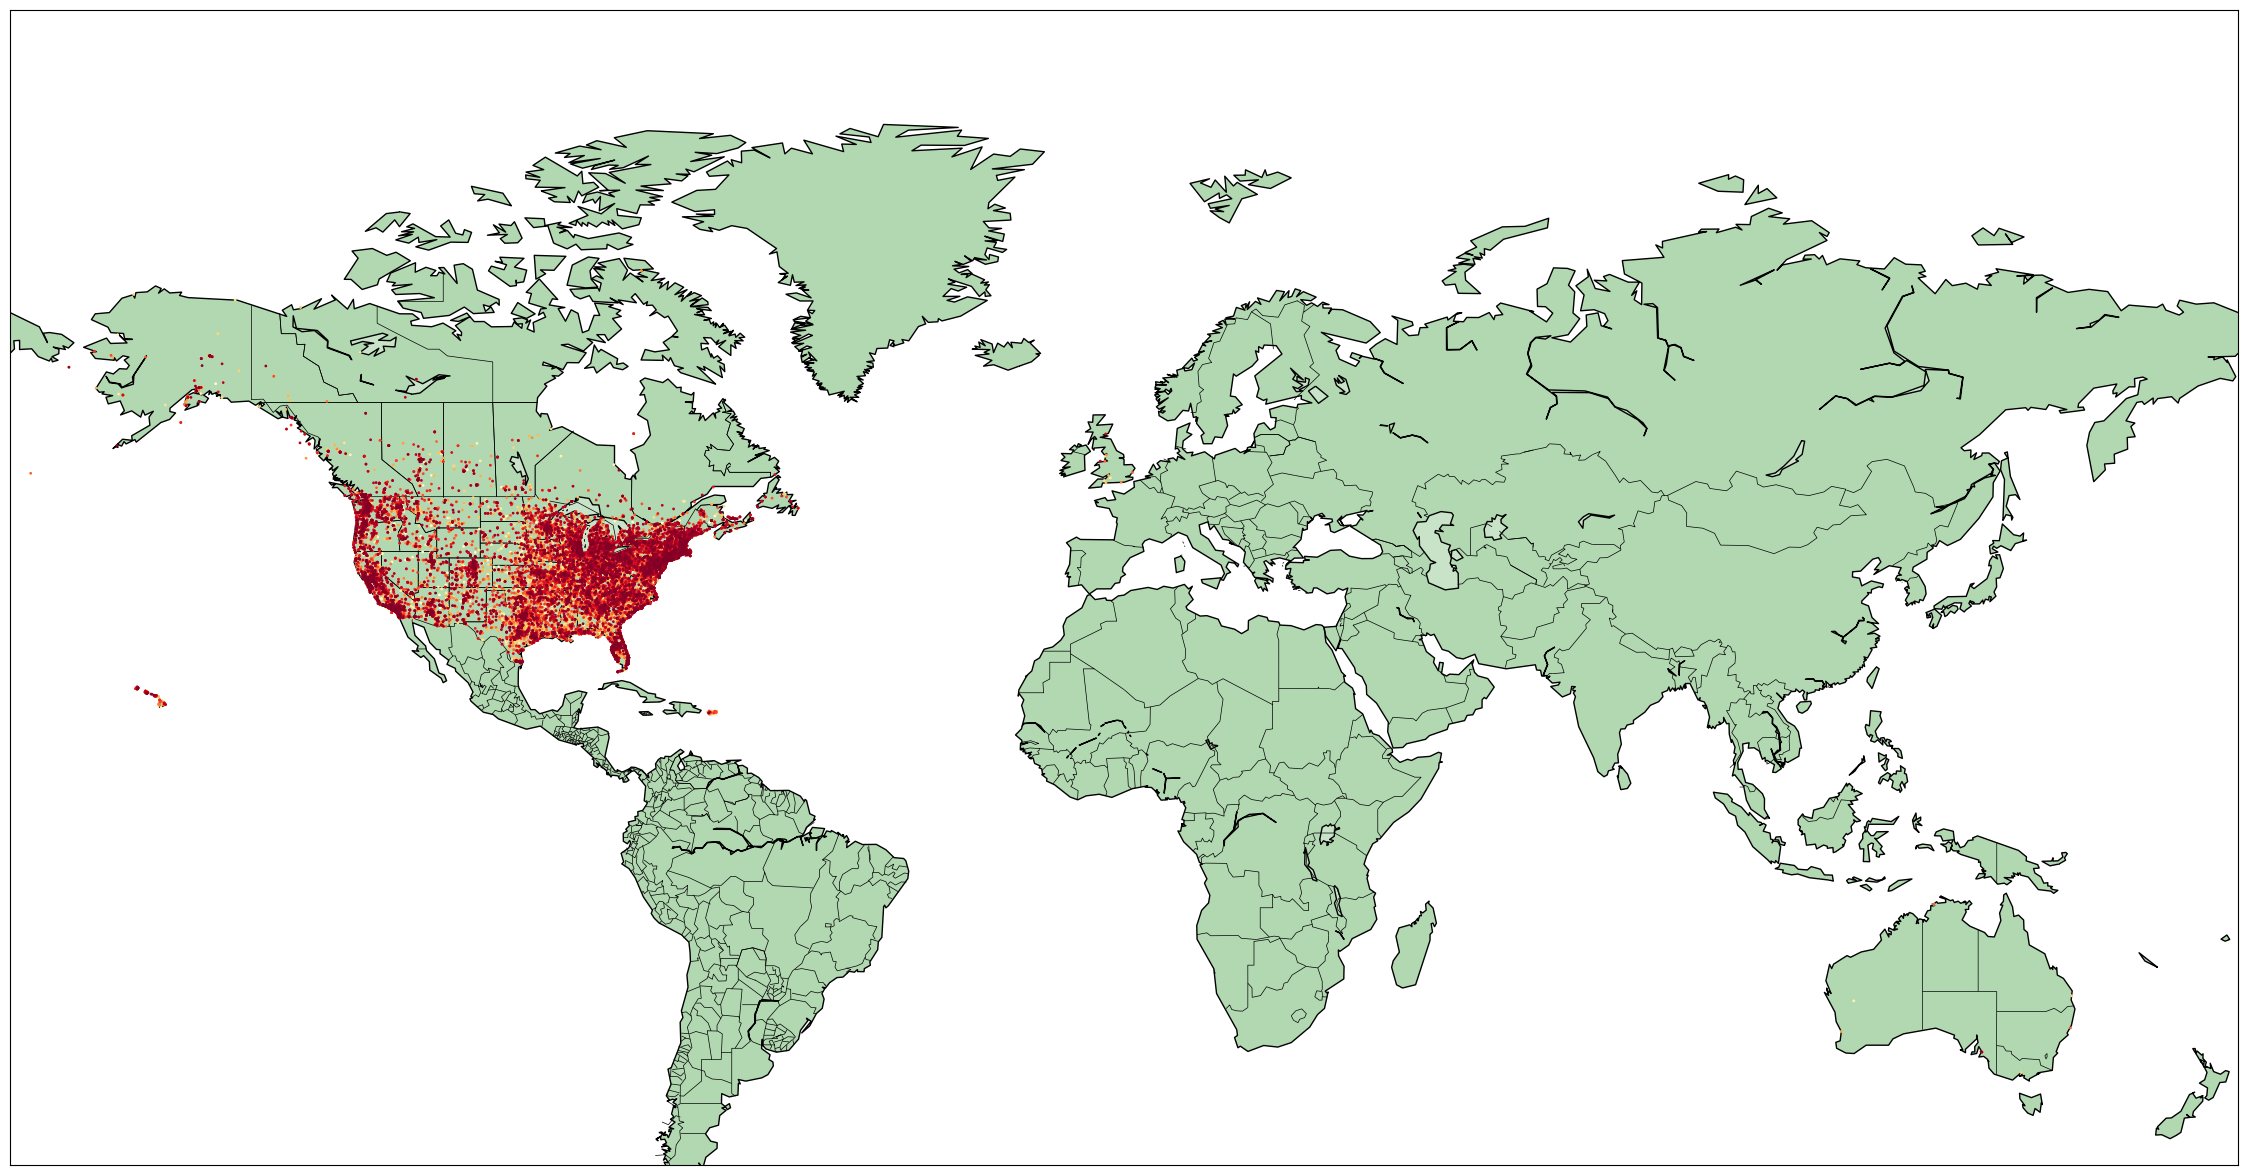

In [18]:
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(30,15))
m = Basemap(projection='mill',
           llcrnrlat = -50,
           urcrnrlat = 90,
           llcrnrlon = -180,
           urcrnrlon = 180,
           resolution = 'c')

m.drawstates()
m.drawcountries()
m.drawcoastlines()

lat, long = df['latitude'].tolist(), df['longitude'].tolist()

t = np.arange(66516)

m.scatter(long, lat, marker = 'o', c=t, cmap='YlOrRd', s=1, zorder=10, latlon=True)
m.fillcontinents(color='g', alpha =0.3)


plt.show()

## Drop all countries which are not the US to eliminate bias

In [19]:
df = df.sort_values('date posted',ascending=True).reset_index(drop=True)

df = df[df['country'] == 'us']

In [20]:
df.describe().style.background_gradient(cmap ='coolwarm').set_properties(**{'font-size': '14px'})

,duration (seconds),latitude,longitude
count,63553.000000,63553.000000,63553.000000
mean,1276.633720,38.323067,-95.578241
std,11759.785729,5.554694,18.061096
min,0.010000,17.967778,-176.658056
25%,30.000000,34.098333,-114.362778
50%,180.000000,38.951667,-89.985833
75%,600.000000,41.900000,-80.912222
max,604800.000000,70.636944,-65.831667


# Data formatting to make calculations easier later on

In [28]:
df['datetime'] = df['datetime'].str.replace("24:00", "00:00")

df['datetime'] = pd.to_datetime(df['datetime'], format="%m/%d/%Y %H:%M")
df['datetime'] = pd.to_datetime(df['datetime'])

ufo_yr = df['datetime'].dt.year

years_data = ufo_yr.value_counts()
years_index = years_data.index
years_values = years_data.values

# Median Year

In [32]:
df['datetime'].dt.year.median()

2007.0

## Frequency vs Duration Graph with Logarithmic Regression Line

In [23]:
df['duration (seconds)'].value_counts()

duration (seconds)
300.00     6972
120.00     5696
600.00     5015
60.00      4610
180.00     4094
           ... 
180.39        1
599.00        1
835.00        1
1133.00       1
47.00         1
Name: count, Length: 460, dtype: int64

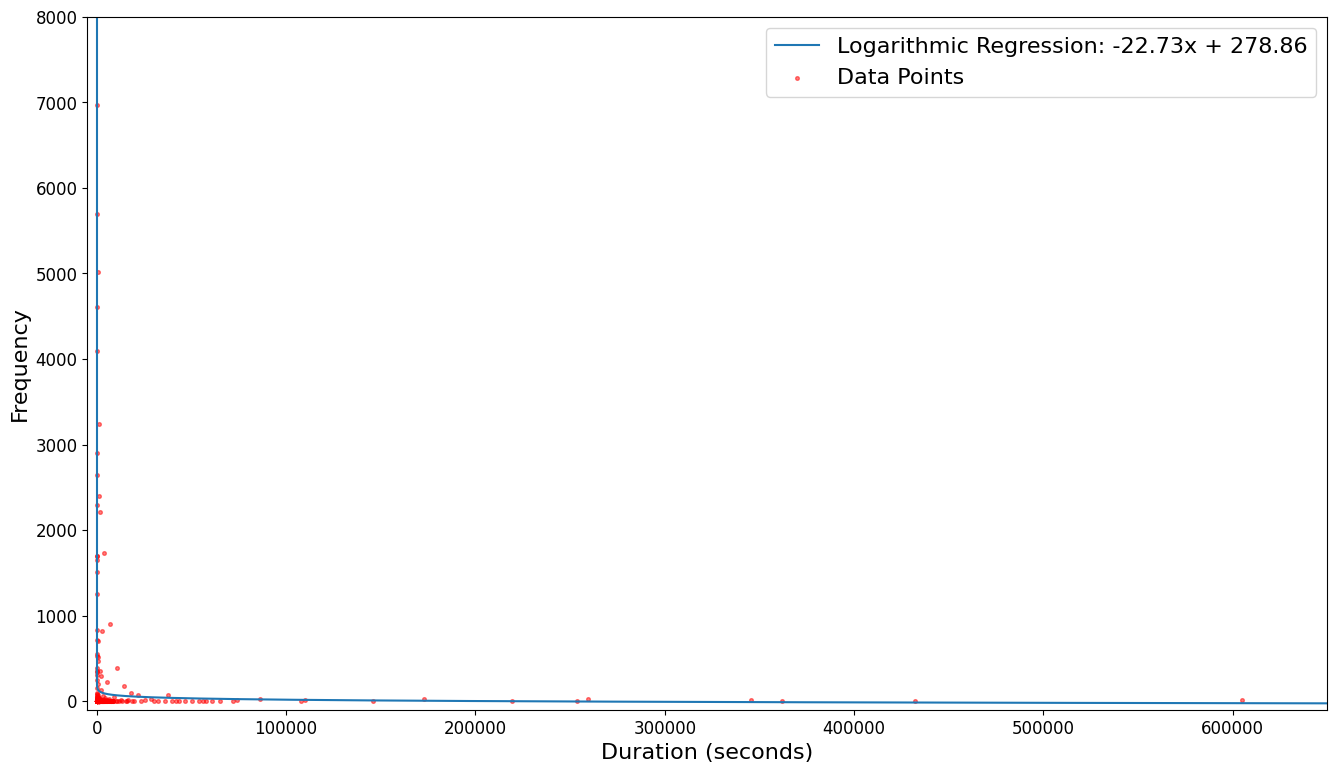

In [22]:
x = df['duration (seconds)'].value_counts().sort_index().index.to_numpy()
y = df['duration (seconds)'].value_counts().sort_index().values

coefficients = np.polyfit(np.log(x), y, 1)
log_reg_line = np.poly1d(coefficients)

x_range = np.linspace(0.01, 650000, 10000)  
y_pred = log_reg_line(np.log(x_range))

plt.figure(figsize=(16, 9))
plt.plot(x_range, y_pred, label=f'Logarithmic Regression: {coefficients[0]:.2f}x + {coefficients[1]:.2f}')
plt.scatter(x, y, color='red', label='Data Points', s=7, alpha=0.5)

plt.axvline(x=0, ymin=0.05, ymax=1)

plt.xlabel('Duration (seconds)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(fontsize=16)
plt.xlim(-5000, 650000)
plt.ylim(-100, 8000)
plt.tick_params(axis='both', labelsize=12)

plt.show()

## Boxplot for Duration

<Axes: >

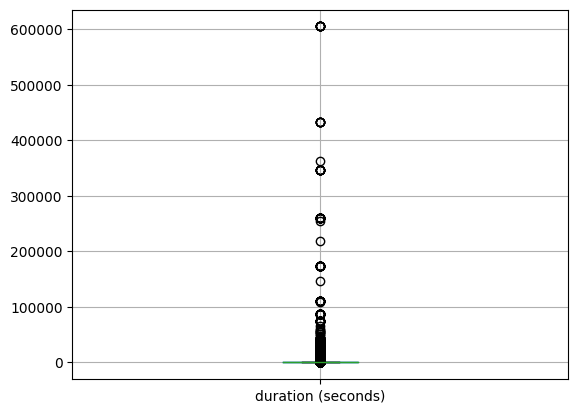

In [24]:
df.boxplot(column='duration (seconds)')

## Z-score for 600000 seconds

In [25]:
import scipy.stats

# Assuming df is your DataFrame
data = df['duration (seconds)']

z_scores = scipy.stats.zscore(data)

print("Z-scores:", z_scores.max())

Z-scores: 51.32135299315101
